# Let's Train SmolLM 135M



### Configure the machine and install packages


In [1]:
import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

ERROR:2025-07-20 14:19:29,924:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/tmp/ipykernel_4514/3043942054.py", line 12, in <module>
    import google.colab
ModuleNotFoundError: No module named 'google.colab'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/workspace/jaxpt/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 197, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspace/jaxpt/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.i

Running on darwin


In [ ]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

from jax.sharding import Mesh, PartitionSpec, NamedSharding

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

mesh = Mesh(devices, ("devices",))
spec = PartitionSpec("devices",)
sharding = NamedSharding(mesh, spec)

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.6.2
Flax version 0.10.4
Available devices: 1


/tmp/ipykernel_4514/1227370322.py:28: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


143 ms ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize SmolLLM model and perform a sanity check

In [4]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import SmolLM, SmolLM_Config
from jaxpt.models.smol_lm import from_hf_pretrained
from jaxpt.utils import count_params, create_sharded_model

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = SmolLM_Config(dtype=jnp.bfloat16, \
                    vocab_size=49152,
                    block_size=2048,
                    n_embed=576,
                    n_head=9,
                    n_kv_head=3,
                    n_mlp_hidden=1536,
                    use_cache=False,
                    mesh=mesh,
                    sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
with mesh:
    m = create_sharded_model(SmolLM, config, rngs)
    #m = SmolLM(config, rngs)
    #graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    #nnx.display(state)
    #m = load_checkpoint("run_20250311_uqdwjq", 5600)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)

    print(f"Parameter Count: {total_params:,}")
    nnx.display(state)

    enc = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    #completions = generate_completions(m, enc=tokenizer, num_completions=5, max_length=21, prefix="Ducks quack, donkeys bray, cats mew, horses")
    #for completion in completions:
    #    print(completion)

Parameter Count: 134,515,008


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [5]:
jax.debug.visualize_array_sharding(state.wte.embedding.value)

         
         
         
         
         
  CPU 0  
         
         
         
         
         

### Configure Training Run

In [6]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/workspace/runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250720_uhajfv
Checkpoint directory: /checkpoints
Log directory: /logs


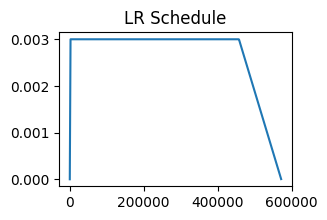

weight decay param count: 134,479,872
tokens/batch: 1,048,576
block size: 2048
batch size: 64
no. gradient accumulation steps: 8
effective batch size: 512
effective batch size per device:  512
max steps: 572,204


In [7]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens: int = int(600e9)
  num_tokens_per_batch: int = 2**20 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 64 * num_devices
  T: int = 2048
  max_steps: int = num_tokens // num_tokens_per_batch
  max_lr: float = 3e-3
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 2000
  print_interval: int = 100 
  eval_interval: int = 10000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
    #optax.adafactor(weight_decay_rate=0.01, weight_decay_mask=weight_decay_mask),
    #optax.adam(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [8]:
from jaxpt.dataloaders import HuggingfaceDataLoader, CloudDataLoader, BlendedCloudDataLoader

batch_size = trconf.T * trconf.mB * trconf.grad_accumulation_steps
batch_memory = batch_size*2
print(f"Batch Size (Tokens): {batch_size:,} | Batch Memory: {batch_memory/1024} MB")

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB * DATA_DIMS,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
'''
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

'''
train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")
'''

train_dl = BlendedCloudDataLoader(
    device_rank=1,
    block_size=trconf.T,
    batch_size=trconf.mB,
    bucket_names=["jaxpt_datasets", "jaxpt_datasets", "jaxpt_datasets"],
    bucket_prefixes=["smollm-corpus/processed/fineweb-edu-dedup",
    "smollm-corpus/processed/python-edu",
    "smollm-corpus/processed/cosmopedia-v2"],
    proportions=[87, 2, 11],
    label="train"
)

Batch Size (Tokens): 1,048,576 | Batch Memory: 2048.0 MB



KeyboardInterrupt



## Test Dataloader Speed

In [ ]:
import time
start = time.time()
for i in range(1000):
    x, y = train_dl()
avg_time = (time.time() - start) / 1000
print(f"batch load time: {avg_time:.2f}")
tok_per_sec = x.size / avg_time
print(f"tokens per second: {tok_per_sec:,.2f}") 

batch load time: 0.02
tokens per second: 6,668,754.07


In [ ]:
from jaxpt.utils import append_to_csv

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0
start = None

In [ ]:
%matplotlib inline

import time

import matplotlib.pyplot as plt


def loss_fn(model, batch, targets):
    logits = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    return loss.mean()


@nnx.jit
def train_step(model, optimizer, batch, targets):
    loss, grads = nnx.value_and_grad(loss_fn, has_aux=False)(model, batch, targets)
    optimizer.update(grads)
    return loss

with mesh:
  m.train()
  try:
    while step < trconf.max_steps:
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), sharding)
      target = jax.device_put(target.squeeze(), sharding)
      loss = train_step(m, optimizer, batch, target)
      if step % trconf.print_interval == 0:
        if not start:
          start = time.time()
          iter_time = -1
          sub_step_time = -1
          tokens_per_sec = -1
        else:
          iter_time = (time.time() - start) / trconf.print_interval
          sub_step_time = iter_time / trconf.grad_accumulation_steps
          tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time

        tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T
        lr = trapezoidal_schedule(step)
        train_losses.append((step, loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.2e} | "
              f"loss: {loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
        start = time.time()
      if step % trconf.eval_interval == 0:
        #save_checkpoint(m, run_dirname, step)
        pass
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(5, 3))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.yticks(ticks=np.arange(2, 12, 0.5))
  plt.grid()
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()


(adamw) 1000 iter , 5.35
(adafactor) 1000 iter, 

In [ ]:
with mesh:
    m.eval()
    completions = generate_completions(m, enc=enc, max_length=20)
    for completion in completions:
        print(completion)

: 